# 7-7. 프로젝트: 인물 모드 문제점 찾기

# 목차

1. 인물모드 직접 해 보기
    - 인물 아웃 포커싱
    - 고양이 아웃 포커싱
    - 크로마키 배경
2. 해결 방법을 제안해 보기
3. 회고

# 루브릭 평가 기준

|평가기준   |상세기준   |
| :------------ | :------------ |
|1. 인물모드 사진을 성공적으로 제작하였다.   | 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다. |
| 2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.  |  인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다. |
| 3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.  |  추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다. |

## 인물 아웃 포커싱

## 인물 1번

### 라이브러리

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

### 이미지 가져오기

(832, 547, 3)


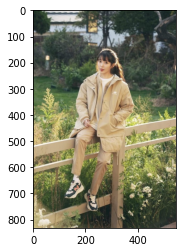

In [169]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/iu.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션 모델 가져오기

In [170]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')


model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
urllib.request.urlretrieve(model_url, model_file)


('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7feaa8d69d00>)

In [171]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

### 모델에 이미지 입력

In [172]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [173]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

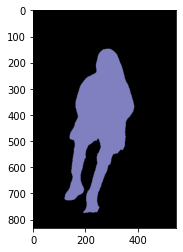

In [174]:
plt.imshow(output)
plt.show()

In [175]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [430]:
# 이미지 상의 들어가 있는 라벨
for i, class_id in enumerate(segvalues['class_ids']):
    print(i, LABEL_NAMES[class_id])

0 background
1 person


In [177]:
colormap =np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype =int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [178]:
colormap[15]

array([192, 128, 128])

In [179]:
seg_color = (128,128,192)

### 사람 색 변경

(832, 547)


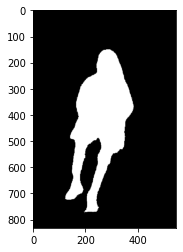

In [180]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

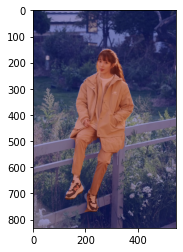

In [181]:
img_show = img_orig.copy()

img_mask =seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 이미지 blur

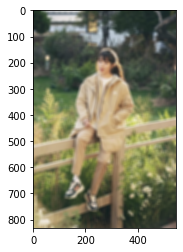

In [182]:
img_orig_blur = cv2.blur(img_orig, (13, 13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 추출

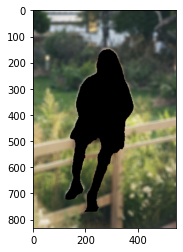

In [184]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 사람과 배경 합치기

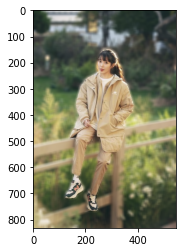

In [40]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점

- 신발 그림자도 인물로 판단하고 블러처리를 안함

## 함수화

In [3]:
'''
print_img 함수
img: 이미지
color: true, false 타입 
'''
def print_img(img, color=True):
    if color:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        plt.imshow(img)
        plt.show()

In [4]:
'''
기본 세팅하는 함수
이미지 path와 model path의 입력
'''
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
def setting(img_path, model_dir):
    img_orig = cv2.imread(img_path)
    print_img(img_orig)
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
    
    urllib.request.urlretrieve(model_url, model_file)

    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)
    segvalues, output = model.segmentAsPascalvoc(img_path)
    print_img(output, False)
    
    
    for class_id in segvalues['class_ids']:
        print(class_id, LABEL_NAMES[class_id])

    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype =int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
        
    return img_orig, output, colormap

In [12]:
'''
colormap 순서 변경
num : 원하는 LABEL_NAMES 위치(int)
'''
def color(colormap, num=15):
    seg_color = (colormap[num][2], colormap[num][1], colormap[num][0])
    return seg_color

In [13]:
'''
이미지 블러 처리하는 함수
'''
def making_blur(output, seg_color, img_orig):
    seg_map = np.all(output==seg_color, axis=-1)
    print_img(seg_map, False)
    img_show = img_orig.copy()

    img_mask =seg_map.astype(np.uint8) * 255

    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
    print_img(img_show)
    
    img_orig_blur = cv2.blur(img_orig, (13, 13))
    print_img(img_orig_blur)
    
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    print_img(img_bg_blur)
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    print_img(img_concat)
    return img_concat

### 인물 2번

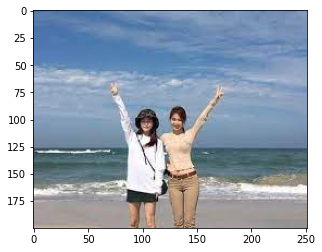

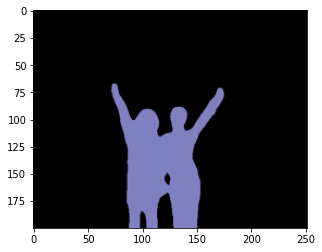

0 background
15 person


In [14]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/h2.jpg'
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
img_orig, output, colormap = setting(img_path, model_dir)

In [15]:
seg_color = color(colormap, 15)
seg_color

(128, 128, 192)

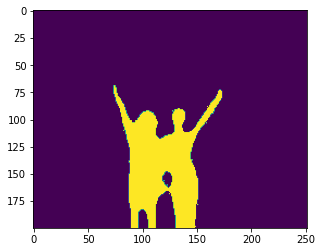

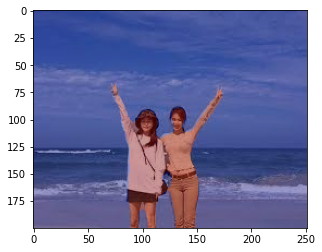

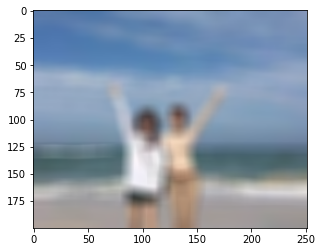

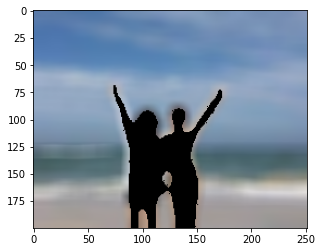

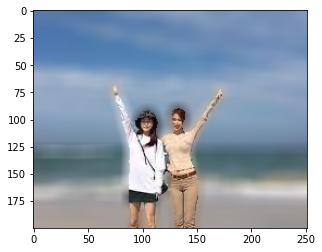

In [16]:
img_concat = making_blur(output, seg_color, img_orig)

### 문제점

- 인물 라인을 따라서 부자연 스러운 블러 처리
- 들고 있는 손이 제대로 불러 처리가 안됨

### 인물 3번

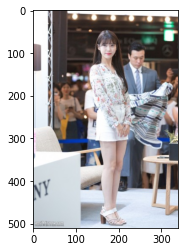

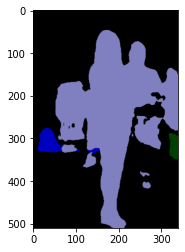

0 background
9 chair
15 person
16 pottedplant


In [17]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/h3.jpg'
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
img_orig, output, colormap = setting(img_path, model_dir)

In [18]:
seg_color = color(colormap, 15)
seg_color

(128, 128, 192)

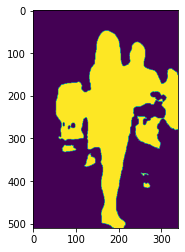

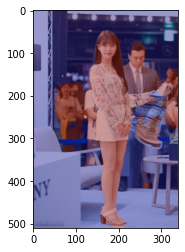

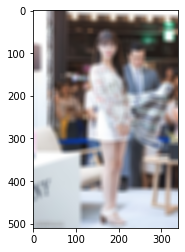

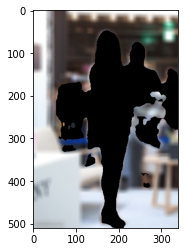

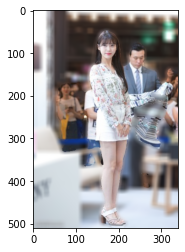

In [19]:
img_concat = making_blur(output, seg_color, img_orig)

### 문제점

- 원하지 않는 인물이 블러처리가 안됨

## 고양이 아웃 포커싱

### 고양이 1번

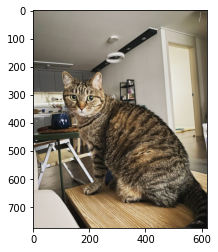

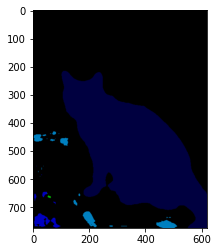

0 background
8 cat
9 chair
11 diningtable
18 sofa


In [20]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/cat.jpg'
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
img_orig, output, colormap = setting(img_path, model_dir)

In [21]:
seg_color = color(colormap, 8)
seg_color

(0, 0, 64)

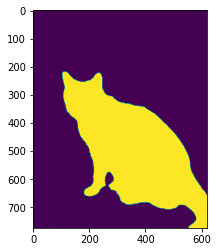

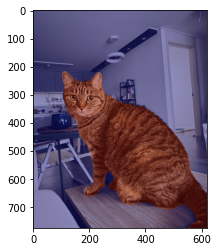

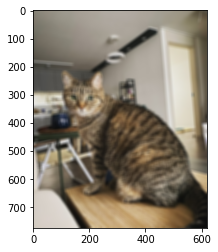

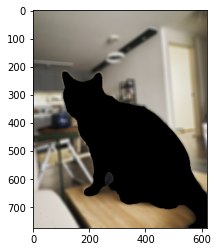

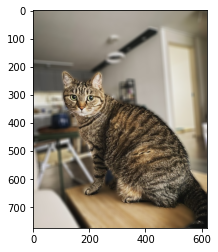

In [22]:
img_concat = making_blur(output, seg_color, img_orig)

### 고양이 2번 

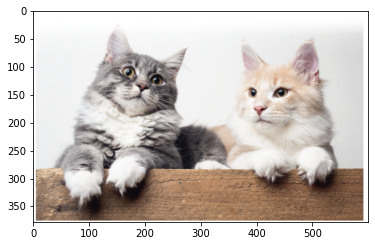

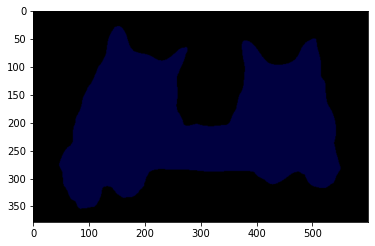

0 background
8 cat


In [23]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/c2.png'
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
img_orig, output, colormap = setting(img_path, model_dir)

In [24]:
seg_color = color(colormap, 8)
seg_color

(0, 0, 64)

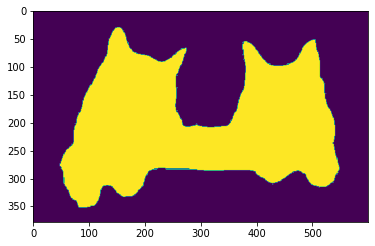

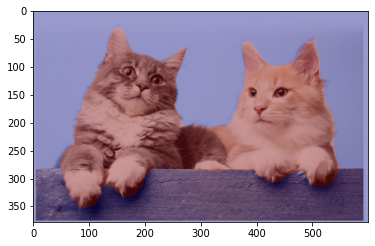

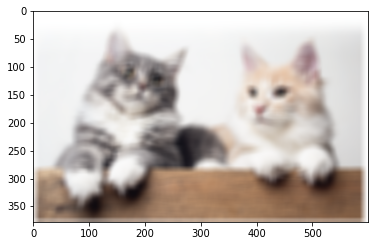

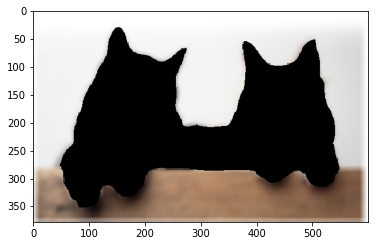

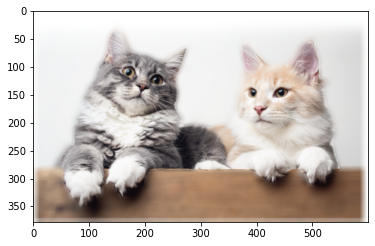

In [25]:
img_concat = making_blur(output, seg_color, img_orig)

### 고양이 3번

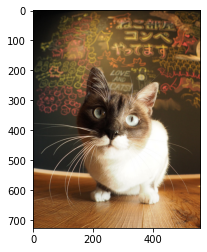

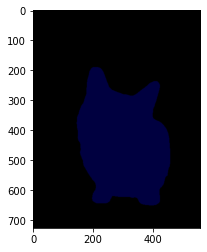

0 background
8 cat


In [26]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/c3.jpg'
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
img_orig, output, colormap = setting(img_path, model_dir)

In [27]:
seg_color = color(colormap, 8)
seg_color

(0, 0, 64)

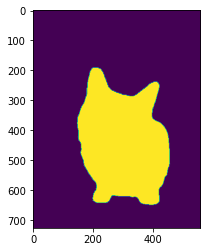

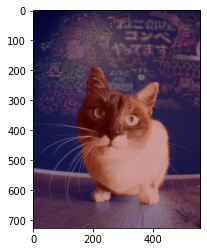

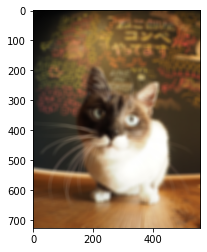

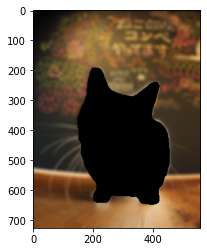

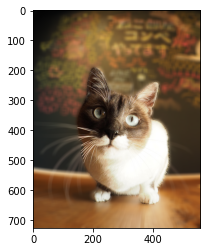

In [28]:
img_concat = making_blur(output, seg_color, img_orig)

## 인물과 배경 합치기

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [8]:
def setting2(img_path, img_background_path, model_dir):
    # 합성 이미지
    img_orig = cv2.imread(img_path)
    # 배경 이미지
    img_background = cv2.imread(img_background_path)
    print_img(img_orig)
    print_img(img_background)
    
    # 모델
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
    urllib.request.urlretrieve(model_url, model_file)
    
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)
    segvalues, output = model.segmentAsPascalvoc(img_path)
    print_img(output, False)
    
    for class_id in segvalues['class_ids']:
        print(class_id, LABEL_NAMES[class_id])
        
    colormap =np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype =int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
        
    return img_orig, img_background, output, colormap

In [9]:
# 인물을 자르는 함수
def cut(output, seg_color, img_orig):
    seg_map = np.all(output==seg_color, axis=-1)
    print(seg_map.shape)
    print_img(seg_map, False)
    
    img_show = img_orig.copy()
    img_mask =seg_map.astype(np.uint8) * 255
    print_img(img_mask)
    
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    print_img(img_mask_color)
    print_img(img_bg_mask)
    
    cut_img = np.where(img_bg_mask == 0, img_show, 255)
    print_img(cut_img)
    
    return cut_img

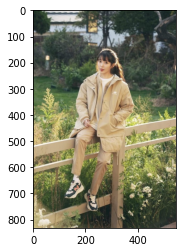

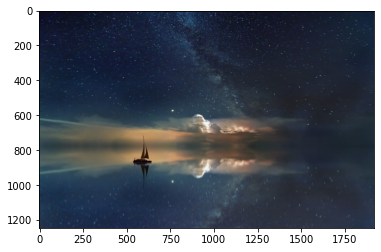

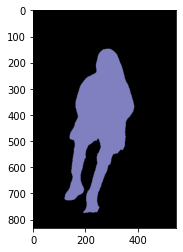

0 background
15 person


In [34]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/iu.jpg'
img_background_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/b.jpg'
img_orig, img_background, output, colormap = setting2(img_path, img_background_path, model_dir)

In [35]:
seg_color = color(colormap, 15)
seg_color

(128, 128, 192)

(832, 547)


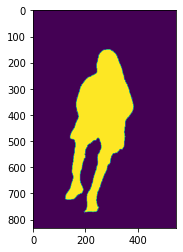

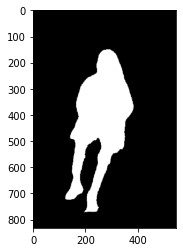

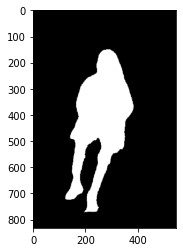

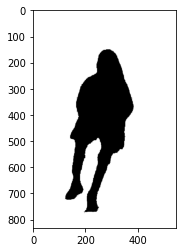

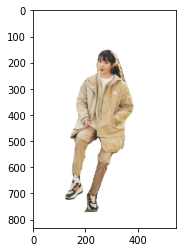

In [36]:
cut_img = cut(seg_color, img_orig)

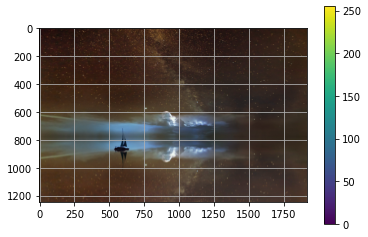

In [31]:
# 배경 확인
plt.figure()
plt.imshow(img_background)
plt.colorbar()
plt.grid()
plt.show()

In [51]:
# 사각형 위치 설정
h1 = 200
w1 =1000
h2 = cut_img.shape[0] + h1
w2 = cut_img.shape[1] + w1
print(w, h)

1547 1032


In [52]:
# 배경 복사본 만들기
img_background_copy = img_background.copy()
print(cut_img.shape)
print(img_background.shape)

(832, 547, 3)
(1246, 1920, 3)


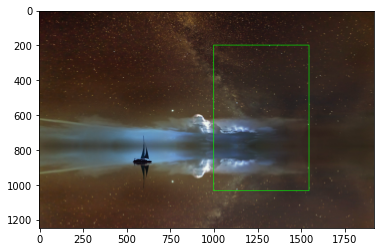

In [53]:
# 배경 복사본에 사각형 그리기
cv2.rectangle(img_background_copy, (w1, h1), (w2, h2), (0, 255, 0), 2, lineType=cv2.LINE_AA)
plt.imshow(img_background_copy)
plt.show()

In [54]:
refined_x = w1
refined_y = h1
print(refined_x, refined_y)

1000 200


### 배경에 인물 사진 넣기

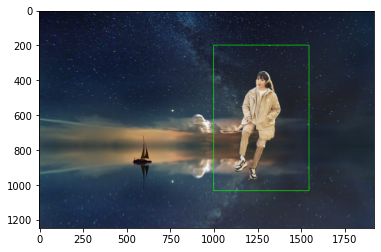

In [55]:
# 복사본에 인물 사진 합성
area = img_background_copy[refined_y:refined_y+cut_img.shape[0], refined_x:refined_x+cut_img.shape[1]]
img_background_copy[refined_y:refined_y+cut_img.shape[0], 
                    refined_x:refined_x+cut_img.shape[1]] = np.where(cut_img==255, area,cut_img).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_background_copy, cv2.COLOR_BGR2RGB))
plt.show()

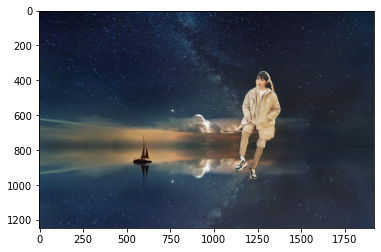

In [56]:
# 원본 배경에 인물 사진 합성
area = img_background[refined_y:refined_y+cut_img.shape[0], refined_x:refined_x+cut_img.shape[1]]
img_background[refined_y:refined_y+cut_img.shape[0], 
                    refined_x:refined_x+cut_img.shape[1]] = np.where(cut_img==255, area,cut_img).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_background, cv2.COLOR_BGR2RGB))
plt.show()

## 해결 방법을 제안해 보기

### opencv에서 제공하는 다른 blur 사용해 보기 
#### Gaussian Filtering

가우시안 필터를 평균 필터와 비교했을 때,
평균필터는 비교적 윤곽선이 살아나면서 블러처리가 되고,
가우시안 필터는 윤곽선도 흐려지는 결과를 얻게 된다.  
https://diyver.tistory.com/67

In [61]:
'''
가우시안 블러 처리하는 함수 
'''
def gmaking_blur(output, seg_color, img_orig):
    seg_map = np.all(output==seg_color, axis=-1)
    print_img(seg_map, False)
    img_show = img_orig.copy()

    img_mask =seg_map.astype(np.uint8) * 255

    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
    print_img(img_show)
    
    img_orig_blur = cv2.GaussianBlur(img_orig, (13, 13), 1)
    print_img(img_orig_blur)
    
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    print_img(img_bg_blur)
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    print_img(img_concat)
    return img_concat

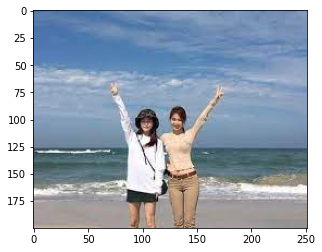

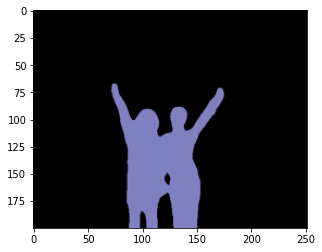

0 background
15 person


In [62]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/h2.jpg'
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
img_orig, output, colormap = setting(img_path, model_dir)

In [63]:
seg_color = color(colormap, 15)
seg_color

(128, 128, 192)

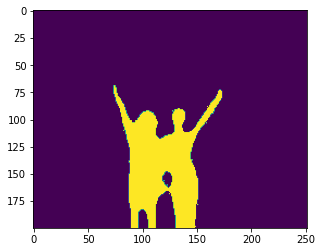

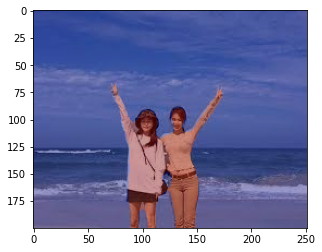

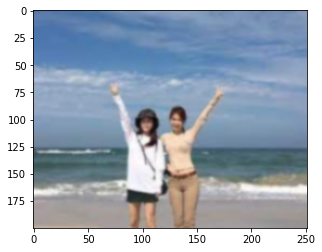

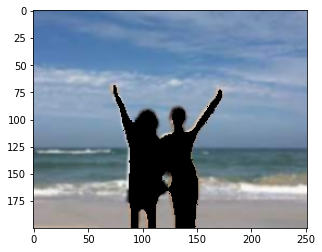

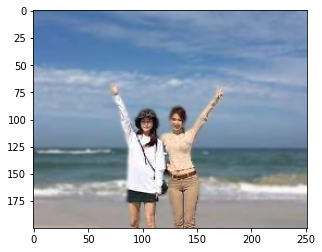

In [64]:
img_concat = gmaking_blur(output, seg_color, img_orig)

#### img_orig_blur = cv2.GaussianBlur(img_orig, (13, 13), 0)
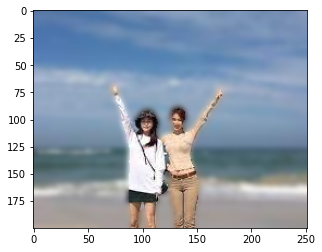
#### img_orig_blur = cv2.GaussianBlur(img_orig, (13, 13), 1)
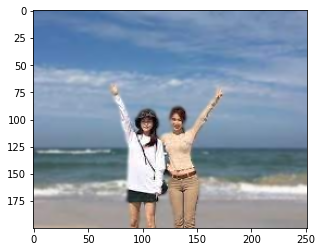
#### img_orig_blur = cv2.GaussianBlur(img_orig, (13, 13), 3)
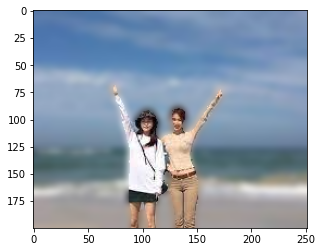


- 마지막 위치의 숫자가 증가 할 수록 블러가 진하게 됨
- 1을 넣었을때 가장 자연스러운 블러처리가 되었다.
- 손가락은 너무 작어서 세그멘테이션에서 인식을 잘 못함

#### 미디안 블러

무작위 노이즈를 제거하는데 효과적입니다.

In [98]:
'''
미디안 블러 처리하는 함수 
'''
def mmaking_blur(output, seg_color, img_orig):
    seg_map = np.all(output==seg_color, axis=-1)
    print_img(seg_map, False)
    img_show = img_orig.copy()

    img_mask =seg_map.astype(np.uint8) * 255

    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
    print_img(img_show)
    
    img_orig_blur = cv2.medianBlur(img_show, 5)
    print_img(img_orig_blur)
    
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    print_img(img_bg_blur)
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    print_img(img_concat)
    return img_concat

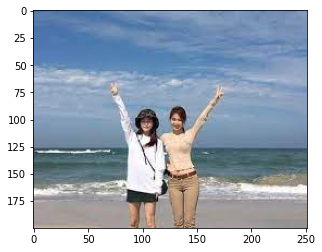

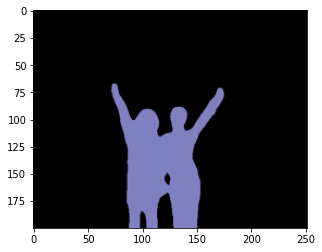

0 background
15 person


In [99]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/h2.jpg'
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
img_orig, output, colormap = setting(img_path, model_dir)

In [100]:
seg_color = color(colormap, 15)
seg_color

(128, 128, 192)

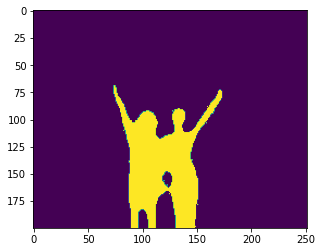

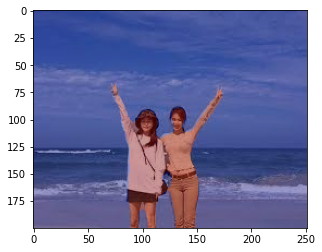

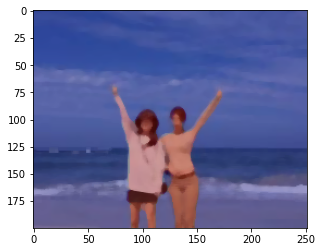

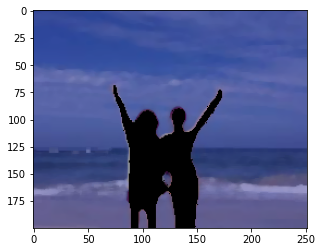

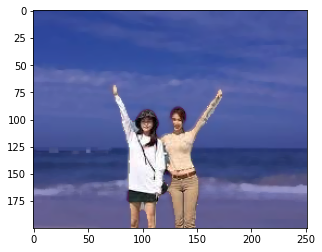

In [101]:
img_concat = mmaking_blur(output, seg_color, img_orig)

## 회고

### 문제점
- 고양이 이미지 블러시 고양이 수염이 길어서 인식하지 못했습니다.
    - 이 경우에는 좋은 이미지를 사용하는 것이 가장 좋은 해결책 인 것 같습니다.
- 사람에 붙어있는 작은 그림자는 블러 처리가 되지 않습니다.
- 인물 3번은 사람이라는 label로 같이 잡혀서 블러 처리가 되지 않습니다.
    - Instance Segmentation을 이용하여 처리해야 합니다.
- 인물 2번은 경계선의 블러 처리가 아쉬운데 이것은 Gaussian Filtering을 이용하여 어느 정도 해결했습니다.
    

### 아쉬운 점
- 이번 프로젝트에서 Mask R-CNN (Instance Segmentation) 사용하기 위해서 세팅을 했지만 사용하지 못했습니다.
    - 여기서 사용되는 모델 파일 안에 'tensorflow.contrib' 함수가 사용되는데 텐서플로 2.0 이상 버전에서는 삭제가 되었습니다.
    - 이것을 해결하기 위해서 텐서플로 1.13.1버전으로 변경하려고 했으나 가상환경에서 막혀서 바꾸지 못했습니다.
    - 버전을 삭제 후 1.13.1노로 설치를 하려고 하면 2.31버전으로 재설치가 됩니다.
    - 케라스 버전 또한 다운 그레이드가 필요합니다.

### 느낀 점
- 이번 프로젝트는 문제점 해결 부분이 상당히 어려웠습니다. 이 문제점 해결 방법으로 다른 블러 처리 방법과 Mask R-CNN을 선택해서 해결하려고 했으나 Mask R-CNN에서 버전으로 문제로 시도해보지 못했습니다. 추후 조금 더 공부하여 Mask R-CNN을 적용해 보고 싶습니다. 또한 파이 토치에서도파이토치에서도 비슷한 모델이 있는 것 같습니다. 그것 또한 따로 공부하여 적용해 보고 싶습니다.